# 1D Variability analysis for HBEC IFN experiment

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [18]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [19]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [20]:
adata.shape

(69958, 36588)

### Setup memento

In [21]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [22]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [23]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1, shrinkage=0.5)

### Estimate moments with memento

In [24]:
adata.obs.head(5)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,q,memento_size_factor
AAACCCAAGGAAGTAG-1,1700,donor0,SNG,0,hash-10,d2513_lambda_9,d2513,lambda,9,4297,4297,12191.0,1394.0,11.434665,3,ciliated,0.10425,0.955289
AAACCCAAGGGACTGT-1,839,donor0,SNG,0,hash-3,d2513_alpha_24,d2513,alpha,24,2171,2171,7270.0,386.0,5.309491,5,bc,0.10425,0.824407
AAACCCACAATCTGCA-1,1130,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,3016,3016,9544.0,516.0,5.406538,0,basal,0.10425,0.988939
AAACCCACACGTTCGG-1,989,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,2748,2748,8248.0,583.0,7.068380,19,basal,0.10425,0.915741
AAACCCACAGAACTAA-1,997,donor1,SNG,0,hash-8,d2614_gamma_48,d2614,gamma,48,2885,2885,7765.0,729.0,9.388281,14,bc,0.10425,0.913556


In [25]:
adata_stim = adata.copy()[
    adata.obs.stim.isin(['control', 'beta']) & \
    adata.obs.cell_type.isin(['ciliated'])].copy()

In [26]:
adata_stim.shape

(4620, 36588)

In [27]:
memento.create_groups(adata_stim, label_columns=['time'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)

In [28]:
m, v, rv = adata_stim.uns['memento']['1d_moments']['sg^0']
cv = v/m**2

In [29]:
# m_df, v_df = memento.get_1d_moments(adata_stim, groupby='time')

# m = m_df['time_0']
# v = v_df

In [30]:
# plt.scatter(m_df['time_0'], v_df['time_0'], s=1)

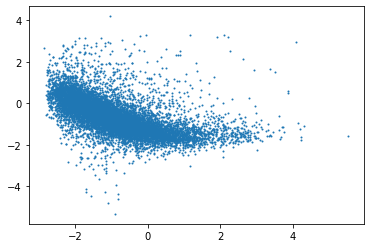

In [31]:
plt.scatter(np.log(m), np.log(cv), s=1)

### Naive estimator

In [33]:
data = adata_stim.X.copy()

In [34]:
sf = data.sum(axis=1)
sf = sf/sf.mean()

In [35]:
relative_data = data / sf#adata_stim.obs['memento_size_factor'].values.reshape(-1,1)

In [36]:
m_naive = relative_data.mean(axis=0).A1
v_naive = relative_data.var(axis=0).A1
cv_naive = v_naive/m_naive**2

(-3, 5)

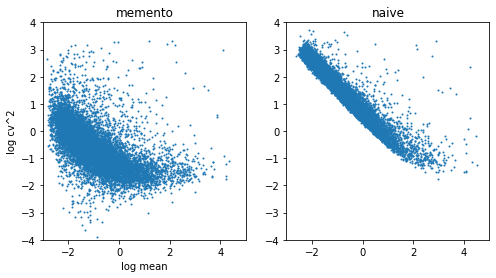

In [41]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.title('memento')
plt.scatter(np.log(m), np.log(cv), s=1)
plt.ylim(-4,4);plt.xlim(-3, 5)
plt.xlabel('log mean'); plt.ylabel('log cv^2')
plt.subplot(1, 2, 2)
plt.title('naive')
plt.scatter(np.log(m_naive), np.log(cv_naive), s=1)
plt.ylim(-4,4);plt.xlim(-3, 5)
